In [5]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# 시드 설정
torch.manual_seed(1)

In [7]:
# 데이터 로딩
file_name = r'C:\VSCode\KDT\Torch_DL\Data\boston_prices.csv'
bostonDF= pd.read_csv(file_name)
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


* 학습방법 : 지도학습 > 회귀
* 알고리즘 : 선형모델 => nn.Linear

In [10]:
# in_features : CRIM, ZN .... , LSTAT
# out_features : MEDV
model = nn.Linear(len(bostonDF.columns[:-1]),1) # 가중치, 절편 생성

In [11]:
# 가중치, 절편 확인
for i in model.named_parameters():
    print(i)

('weight', Parameter containing:
tensor([[-0.1173, -0.2456,  0.1705, -0.0635, -0.1750,  0.0722, -0.2074,  0.1941,
          0.1595, -0.2726, -0.2177, -0.1829, -0.1501]], requires_grad=True))
('bias', Parameter containing:
tensor([0.0346], requires_grad=True))


In [12]:
# 모델의 가중치와 절편 최적화 (인스턴스에 전달)
adam_optim = optim.Adam(model.parameters(),lr=0.1)
# 가중치, 절편을 전달하고 학습률을 설정

In [13]:
# 피쳐, 타겟 분리
featureTS = torch.from_numpy(bostonDF.iloc[:,:-1].values).float()
targetTS = torch.from_numpy(bostonDF[['MEDV']].values).float()

print(f'featureTS : {featureTS.shape}')
print(f'targetTS : {targetTS.shape}')

featureTS : torch.Size([506, 13])
targetTS : torch.Size([506, 1])


In [14]:
# 훈련, 검증, 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS,
                                                    train_size = 0.8, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size = 0.8, random_state = 42)
print(f"train : {X_train.shape}, {y_train.shape}")
print(f"val : {X_val.shape}, {y_val.shape}")
print(f"test : {X_test.shape}, {y_test.shape}")

train : torch.Size([323, 13]), torch.Size([323, 1])
val : torch.Size([81, 13]), torch.Size([81, 1])
test : torch.Size([102, 13]), torch.Size([102, 1])


In [15]:
def testing(X_test,y_test,kind='val'):
    with torch.no_grad(): # 가중치, 절편 업데이트 X
        # (1) 순전파 (학습)
        pred_test_y = model(X_test)

        # (2) 손실 함수 계산
        loss_test = F.mse_loss(y_test,pred_test_y).item()

    return loss_test

In [16]:
def training(X_train,y_train,X_test,y_test,epoch = 10):
    EPOCH = epoch
    loss_train_history = []
    loss_test_history = []
    for i in range(1,EPOCH+1):
        # (1) 순전파 (학습)
        pred_train_y = model(X_train)

        # (2) 손실 함수 계산
        loss_train = F.mse_loss(y_train,pred_train_y)
        loss_test = testing(X_test,y_test)
        loss_train_history.append(loss_train.item())
        loss_test_history.append(loss_test)

        # (3) 최적화
        adam_optim.zero_grad() # 기울기 초기화
        loss_train.backward() # 역전파 하면서 그레디언트 계산
        adam_optim.step() # 가중치, 절편 업데이트

        # (4) 학습 결과 출력
        print(f'[Train : {i}/{EPOCH} : {loss_train}]')
        print(f'[Test : {i}/{EPOCH} : {loss_test}]')

    return loss_train_history, loss_test_history

In [17]:
result = training(X_train,y_train,X_test,y_test)

[Train : 1/10 : 48009.56640625]
[Test : 1/10 : 50761.83984375]
[Train : 2/10 : 16258.4013671875]
[Test : 2/10 : 17006.859375]
[Train : 3/10 : 1672.9825439453125]
[Test : 3/10 : 1643.7369384765625]
[Train : 4/10 : 1416.060791015625]
[Test : 4/10 : 1606.6251220703125]
[Train : 5/10 : 8256.353515625]
[Test : 5/10 : 9108.22265625]
[Train : 6/10 : 13768.3623046875]
[Test : 6/10 : 15096.75390625]
[Train : 7/10 : 14298.232421875]
[Test : 7/10 : 15666.7451171875]
[Train : 8/10 : 10850.2138671875]
[Test : 8/10 : 11918.26953125]
[Train : 9/10 : 5979.7705078125]
[Test : 9/10 : 6611.88671875]
[Train : 10/10 : 1975.885498046875]
[Test : 10/10 : 2218.23876953125]


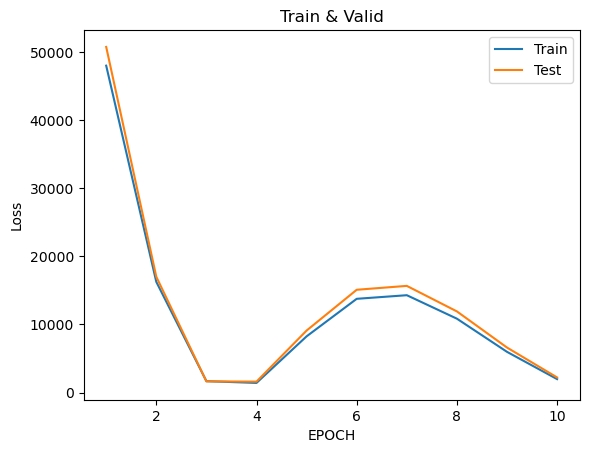

In [18]:
plt.plot(range(1, 11), result[0], label = 'Train')
plt.plot(range(1, 11), result[1], label = 'Test')
plt.title('Train & Valid')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()